In [0]:
# use tensoflow 1.13.1
!pip3 install tensorflow-gpu==1.13.1

# revert to matplot lib 3.1.0 that not cut the confusion matrix
!pip install matplotlib==3.1.0 

# restart runtime and import all

In [1]:
%tensorflow_version 1.x
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

Tensorflow version is  1.13.1


Using TensorFlow backend.


In [2]:
# mount g-drive for save the model
from google.colab import drive
drive.mount('/gdrive')

colabModelFolder = '/gdrive/My Drive/Colab-Model/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Download training set

In [3]:
resizedDataSet = True
if not resizedDataSet:
  # Original kaggle training set ~3GB
  !pip install kaggle
  !mkdir .kaggle
  !cp ./kaggle.json ~/.kaggle/kaggle.json
  !chmod 600 /root/.kaggle/kaggle.json

  !kaggle datasets download -d katexu/trash_detection # https://www.kaggle.com/katexu/trash_detection/data

  # unzip training set
  !unzip -f trash_detection.zip -d trash_dataset
  !rm trash_detection.zip

  dataset_path = "trash_dataset/dataset-original"
else:
  # Resized training set thanks to https://github.com/garythung/trashnet
  !wget -O dataset-resized.zip 'https://www.dropbox.com/s/a2fcno2uzgfn5ij/trash-dataset-resized.zip?dl=0'
  !unzip dataset-resized.zip -d trash_dataset
  dataset_path = "trash_dataset/trash-dataset-resized"

--2019-11-23 09:08:39--  https://www.dropbox.com/s/a2fcno2uzgfn5ij/trash-dataset-resized.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/a2fcno2uzgfn5ij/trash-dataset-resized.zip [following]
--2019-11-23 09:08:39--  https://www.dropbox.com/s/raw/a2fcno2uzgfn5ij/trash-dataset-resized.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc7dce10722963417e3cf0e4646.dl.dropboxusercontent.com/cd/0/inline/As5WB-f2NQy54SDEPSwBeTvzuGpTQCJWLSCmGXI0H2VrsqMeBBRMqsvMSWwR56zKvzYrBHwtbSh49qaIIJj5Xjp_yA5FEBNRQsplY26vpAxsAViZD4C-DfexOrsRTueh1uI/file# [following]
--2019-11-23 09:08:39--  https://ucc7dce10722963417e3cf0e4646.dl.dropboxusercontent.com/cd/0/inline/As5WB-f2NQy54SDEPSwBeTvzuGpTQCJWLSCmGXI0H2VrsqMeBBRMqsvMSWwR56zKvzY

In [0]:
# collpase cardboard and paper into unique class "paper"
collapse = True
if collapse:
  !mv {dataset_path + "/cardboard/*"} {dataset_path + "/paper"}
  !rm -rf {dataset_path + "/cardboard/"}

# remove the trash category
!rm -rf {dataset_path + "/trash/"}

## setup training

In [3]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir(dataset_path)
# split the training set, 13% for validation set, 17% for test set
data_frames = make_dataframe(dataset_path, validation_percentage = 0.13, test_percentage=0.17)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True, # data augmentation
    vertical_flip=True,
    ##zca_whitening=True,
    rotation_range=15.
)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Label:  paper
Total size:  997
Training set size:  699
Validation set size:  130
Test set size:  168
Label:  glass
Total size:  501
Training set size:  351
Validation set size:  66
Test set size:  84
Label:  metal
Total size:  410
Training set size:  288
Validation set size:  54
Test set size:  68
Label:  plastic
Total size:  527
Training set size:  370
Validation set size:  69
Test set size:  88


In [4]:
# make generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=data_frames[0],
    x_col='path',
    y_col='label',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = batch_size)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=data_frames[1],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data_frames[2],
    x_col = 'path',
    y_col = 'label',
    class_mode = 'categorical',
    target_size=(width_image, height_image),
    batch_size = batch_size,
    shuffle=False
)

Found 1708 validated image filenames belonging to 4 classes.
Found 319 validated image filenames belonging to 4 classes.
Found 408 validated image filenames belonging to 4 classes.


In [7]:
#base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape,
#                                                include_top=False,
#                                                weights='imagenet')

# Dense-Net 121 as base CNN
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=img_shape,
                                                include_top=False,
                                                weights='imagenet')

base_model.trainable = False
# feature extraction reuse, T
#for layer in base_model.layers:
#    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 2s 0us/step


## create model over pre-trained net

In [8]:
# create model over pre-trained graph
model = tf.keras.Sequential([
    base_model,
    keras.layers.Dropout(0.5), # dropout for prevent overfitting
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(categories), activation='softmax')
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# add the optmizer, loss function and metric for evaluate the training
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Nadam()
# optimizer = keras.optimizers.Adadelta()
# tensorflow guide use:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Tranining Phase

In [10]:
import math

epochs = 10
steps_per_epoch = math.ceil(train_generator.n / batch_size)
validation_steps = math.ceil(validation_generator.n / batch_size)
test_steps = math.ceil(test_generator.n / batch_size)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs, 
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
54/54 [==============================] - 39s 722ms/step - loss: 1.1168 - acc: 0.5293 - val_loss: 0.8637 - val_acc: 0.6364
Epoch 2/10
54/54 [==============================] - 28s 521ms/step - loss: 0.7143 - acc: 0.7319 - val_loss: 0.6139 - val_acc: 0.7806
Epoch 3/10
54/54 [==============================] - 31s 565ms/step - loss: 0.5510 - acc: 0.8173 - val_loss: 0.5227 - val_acc: 0.8119
Epoch 4/10
54/54 [==============================] - 31s 569ms/step - loss: 0.4851 - acc: 0.8273 - val_loss: 0.4668 - val_acc: 0.8339
Epoch 5/10
54/54 [==============================] - 31s 571ms/step - loss: 0.4464 - acc: 0.8495 - val_loss: 0.4306 - val_acc: 0.8370
Epoch 6/10
54/54 [==============================] - 31s 570ms/step - loss: 0.4381 - acc: 0.8454 - val_loss: 0.3670 - val_acc: 0.8683
Epoch 7/10
54/54 [==============================] - 31s 568ms/step - loss: 0.4201 - acc: 0.8507 - val_loss: 0.3255 - val_acc: 0.8871
Epoch 8/10
54/54 [===

## Fine tuning

In [11]:
# Enable chage of all net weight's including the pre-trained
epochs_fine = 200
print("Number of layers in the base model: ", len(base_model.layers))
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)

Number of layers in the base model:  427


In [0]:
# set the level to fine-tune
fine_tune_at = 313 # 141

base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [13]:
# recompile model with optimizer
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.RMSprop(lr=2e-5)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 2,164,228
Non-trainable params: 4,877,376
_________________________________________________________________


In [14]:
# fit fine-tuning
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = epochs_fine,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

Epoch 1/200
54/54 [==============================] - 36s 663ms/step - loss: 0.3503 - acc: 0.8700 - val_loss: 0.2684 - val_acc: 0.9028
Epoch 2/200
54/54 [==============================] - 29s 537ms/step - loss: 0.3299 - acc: 0.8794 - val_loss: 0.2621 - val_acc: 0.9028
Epoch 3/200
54/54 [==============================] - 31s 570ms/step - loss: 0.3225 - acc: 0.8934 - val_loss: 0.2563 - val_acc: 0.9028
Epoch 4/200
54/54 [==============================] - 31s 578ms/step - loss: 0.2985 - acc: 0.8929 - val_loss: 0.2533 - val_acc: 0.9028
Epoch 5/200
54/54 [==============================] - 31s 573ms/step - loss: 0.2839 - acc: 0.9075 - val_loss: 0.2488 - val_acc: 0.9060
Epoch 6/200
54/54 [==============================] - 31s 576ms/step - loss: 0.3017 - acc: 0.8964 - val_loss: 0.2462 - val_acc: 0.9122
Epoch 7/200
54/54 [==============================] - 31s 575ms/step - loss: 0.3024 - acc: 0.9034 - val_loss: 0.2404 - val_acc: 0.9122
Epoch 8/200
54/54 [==============================] - 31s 572ms

## Plotting Validation accuracy/loss

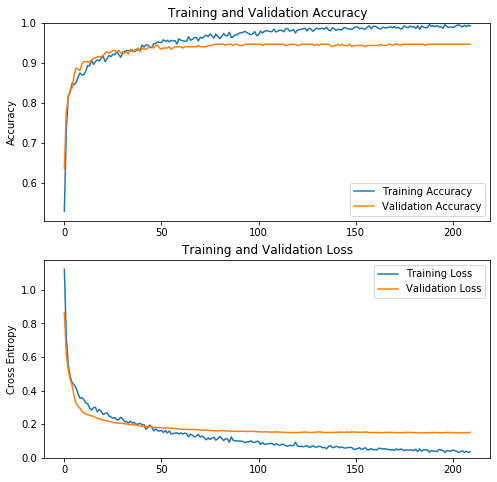

In [15]:
%matplotlib inline

# training and validation accuracy/loss
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

if('history_fine' in globals()):
    acc += history_fine.history['acc']
    val_acc += history_fine.history['val_acc']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## Plotting confusion matrix

Confusion Matrix
[[ 76   6   0   2]
 [  2  64   2   0]
 [  0   1 167   0]
 [  3   1   2  82]]
Classification Report
              precision    recall  f1-score   support

       paper       0.94      0.90      0.92        84
       glass       0.89      0.94      0.91        68
       metal       0.98      0.99      0.99       168
     plastic       0.98      0.93      0.95        88

    accuracy                           0.95       408
   macro avg       0.94      0.94      0.94       408
weighted avg       0.95      0.95      0.95       408

408/408 [==============================] - 4s 11ms/sample - loss: 0.1113 - acc: 0.9534
Accuracy: 95.3%
Loss: 11.1%


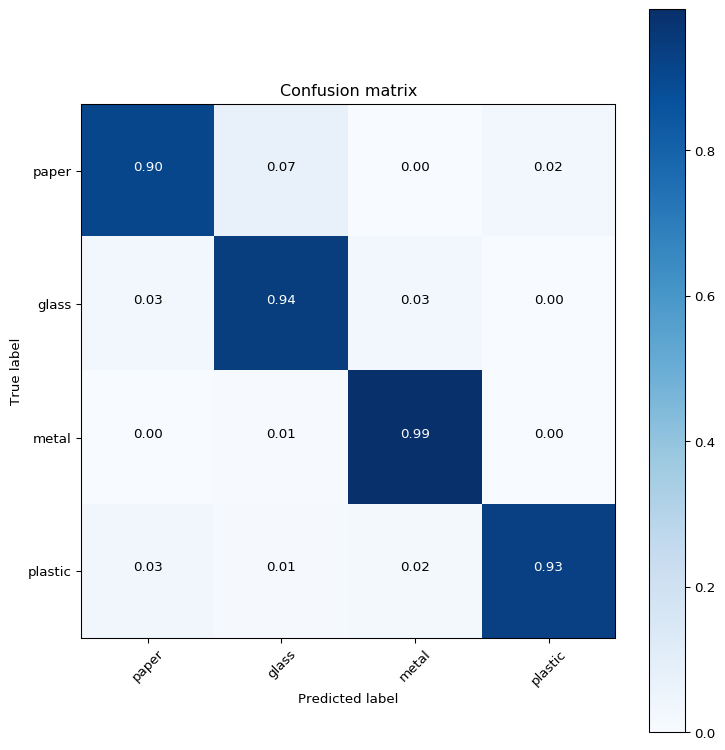

In [10]:
from train_utils import plot_confusion_matrix
# confusion matrix
Y_pred = model.predict_generator(test_generator, test_steps)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# classification report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=categories))

# evaluate keras model with model.evaluate()
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: {0:0.1f}%".format(acc * 100))
print("Loss: {0:0.1f}%".format(loss * 100))


plot_confusion_matrix(test_generator.classes, y_pred, categories)

In [0]:
from zipfile import ZipFile
from datetime import datetime
from subprocess import check_call

def save_notebook_html(name_notebook):
    notebook = name_notebook + ".ipynb"
    return check_call(['jupyter', 'nbconvert', '--to', 'html', notebook])

def notebook_identifier_name(name_notebook):
    return name_notebook + "_" + datetime.now().strftime("%H_%M_%d_%m_%Y")

def compress_model_notebook(name_notebook, model_file_path):
    if save_notebook_html(name_notebook) == 0:
        file = notebook_identifier_name(name_notebook)
        zip_folder = ZipFile(os.path.join("saved_model", file + ".zip"), 'w')
        zip_folder.write(name_notebook + ".html")
        zip_folder.write(model_file_path)
        zip_folder.close()

In [0]:
# save the model
name = notebook_identifier_name('CNN') + '.h5'
model.save(name)

In [0]:
# compress_model_notebook('CNN', name)

In [0]:
# save the model on google drive
!mkdir -p {'\"' + colabModelFolder + '\"'}
!cp {name} {'\"' + colabModelFolder + '\"'}
!cp {name} {'\"' + colabModelFolder + 'CNN-latest.h5' + '\"'}

##### Try to predict with model

In [0]:
# copy model from gdrive
targetName = "CNN-latest.h5"
destName = "CNN.h5"
!cp {'\"' + colabModelFolder + targetName + '\"'} $destName

In [7]:
from tensorflow.keras.models import Model
categories = os.listdir(dataset_path)
loaded_model = keras.models.load_model(destName)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'glass.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = x/255
x = preprocess_input(x)
plt.imshow(img)

In [0]:
preds = model.predict_proba(x)
category = model.predict_classes(x)
print(preds)
print(categories[category.argmax()])

# Training SVM using CNN backbone

In [0]:
# copy model from gdrive
targetName = "CNN-latest.h5"
destName = "CNN.h5"
!cp {'\"' + colabModelFolder + targetName + '\"'} $destName

In [11]:
# load CNN backbone ready for fine-tuning
from tensorflow.keras.models import Model

model = keras.models.load_model(destName)
model.summary()

# remove the last softmax layer
model = Model(model.input, model.layers[-2].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 2,164,228
Non-trainable params: 4,877,376
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121_input (InputLaye (None, 224, 224, 3)       0         
__________________________________________________________

### Feature Extraction from CNN

In [0]:
import os
 
import sklearn
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib
     
def extract_features(generator, model, size):
    features = np.empty((size, 1024))
    labels = []
    for i in range(0, size):
        img, label = generator.next()
        feature = model.predict(img)
        features[i,:] = np.squeeze(feature)
        labels.append(categories[np.argmax(label)])
        print("{0:.0f}%".format((i/size) * 100), end="\r")
    return features, np.array(labels)

In [13]:
# create a generator from all dataset, the svm split into training and test sets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
#    horizontal_flip=True,
#    vertical_flip=True,
#    rotation_range=15.
)

train_svm_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = 1)

Found 2435 images belonging to 4 classes.


In [14]:
features, labels = extract_features(train_svm_generator, model, size=len(train_svm_generator))

### Train SVM

In [0]:
# save 20% of data for performance evaluation
"""
features: array of input features
labels: array of labels associated with the input features
"""
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [16]:
"""
train_svm_classifer will train a SVM, saved the trained and SVM model and
report the classification performance

model_output_path: path for storing the trained svm model
"""
param = [
 #   {
 #       "kernel": ["linear"],
 #       "C": [1, 10, 100, 1000]
 #   },
    {
        "kernel": ["rbf"],
        "C": [10],#[1, 10, 100, 1000],
        "gamma": [1e-2, 1e-3]#, 1e-4, 1e-5]
    }
]

# request probability estimation
svm = SVC(probability=True)

# 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
clf = GridSearchCV(svm, param,
        cv=10, n_jobs=5, verbose=3)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  20 | elapsed:  3.6min remaining:   23.9s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  3.6min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid=[{'C': [10], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)


Best parameters set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Confusion matrix:
Labels: glass,metal,paper,plastic

[[ 89   0   2   0]
 [  0 198   1   0]
 [  0   0  90   2]
 [  0   1   1 103]]

Classification report:
              precision    recall  f1-score   support

       glass       1.00      0.98      0.99        91
       metal       0.99      0.99      0.99       199
       paper       0.96      0.98      0.97        92
     plastic       0.98      0.98      0.98       105

    accuracy                           0.99       487
   macro avg       0.98      0.98      0.98       487
weighted avg       0.99      0.99      0.99       487

Accuratezza media della combinazione migliore: 0.980
Accuratezza sul training set: 0.999
Accuratezza sul validation set: 0.986


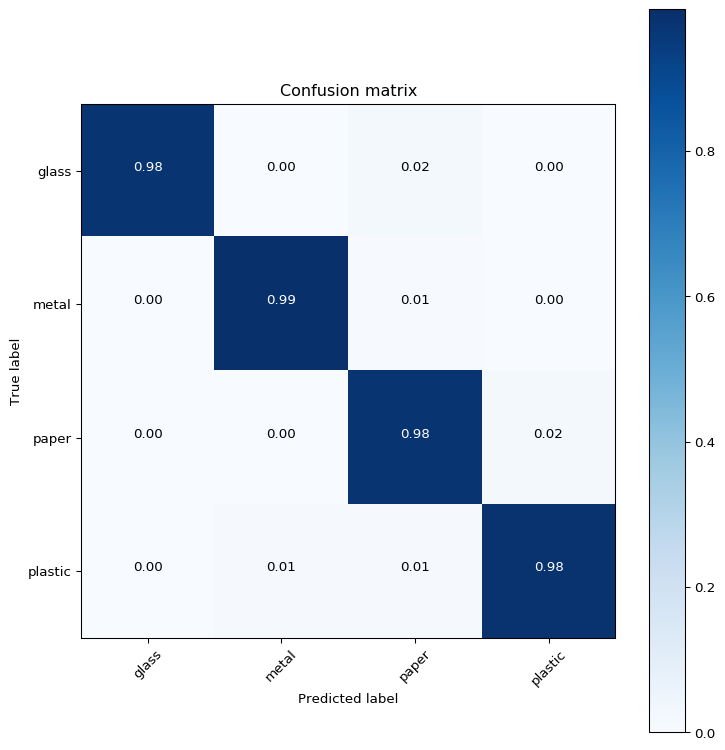

In [17]:
# print svm training info
print("\nBest parameters set:")
print(clf.best_params_)

y_predict=clf.best_estimator_.predict(X_test)

labels = sorted(list(set(labels)))
print("\nConfusion matrix:")
print("Labels: {0}\n".format(",".join(labels)))
print(confusion_matrix(y_test, y_predict, labels=labels))

print("\nClassification report:")
print(classification_report(y_test, y_predict))

# Calcolo accuratezza
print('Accuratezza media della combinazione migliore: %.3f' % clf.best_score_)
print('Accuratezza sul training set: %.3f' % clf.best_estimator_.score(X_train, y_train))
print('Accuratezza sul validation set: %.3f' % clf.best_estimator_.score(X_test, y_test))

plot_confusion_matrix(y_test, y_predict, labels)

In [18]:
output_svm = 'SVM.sav'
output_cnn = 'CNN-backbone.h5'
overwrite = True

if not os.path.exists(output_svm) or overwrite:
    joblib.dump(clf.best_estimator_, output_svm)
    print("Saved to {0}.".format(output_svm))
else:
    print("Cannot save trained svm model to {0}.".format(output_svm))
    
model.save(output_cnn)

Saved to SVM.sav.


In [22]:
# copy to gdrive
import shutil
svmFolderPath = colabModelFolder + "SVM/"
os.makedirs(svmFolderPath, exist_ok=True)
shutil.copy2(output_svm, svmFolderPath)
shutil.copy2(output_cnn, svmFolderPath)

'/gdrive/My Drive/Colab-Model/SVM/CNN-backbone.h5'

##### Try to predict with cnn-svm

In [23]:
loaded_svm = joblib.load('SVM.sav')
print('Accuratezza sul test set: %.3f' % loaded_svm.score(X_test, y_test))

Accuratezza sul validation set: 0.986


In [0]:
# previously loaded and modified for extract the features
loaded_cnn = model

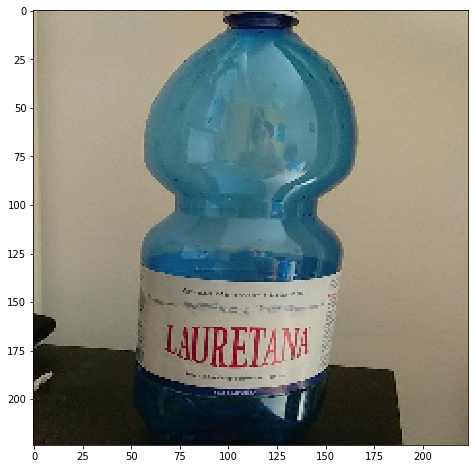

In [27]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'plastic.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255
preprocess_input(x)
plt.imshow(img)

In [28]:
preds = loaded_cnn.predict(x)
loaded_svm.predict(preds)

array(['plastic'], dtype='<U7')

In [29]:
preds = loaded_cnn.predict(x)
loaded_svm.predict_proba(preds)

array([[0.27869715, 0.02564453, 0.03902542, 0.65663289]])